### 调用需要用到的库

In [1]:
import numpy as np
from time import sleep
import time
import matplotlib.pyplot as plt
%matplotlib inline

### 定义辅助函数

In [2]:
def loadDataSet(filename):
    #filename是待读取文件的文件名或路径+文件名
    dataMat=[];labelMat=[]
    fr=open(filename)
    for line in fr.readlines():
        lineArr=line.strip().split("\t")
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

def randPickj(i,m):
    #i是alphai的i值，整数; m是alpha个数; j不能等于i
    j=i
    while j==i:
        j=int(np.random.uniform(0,m))  #np.random.uniform()表示随机生成(0,m)之间的实数
    return j

def clipAlpha(aj,H,L):
    if aj>H:
        aj=H
    if aj<L:
        aj=L
    return aj

### 定义w

In [3]:
def weight(data,label,alphas):
    dataMatrix=np.mat(data);labelMatrix=np.mat(label).transpose() #这里labelMatrix形状为m*1
    m,n=dataMatrix.shape
    w=np.mat(np.zeros((1,n))) #初始化w，为1行n列的全零矩阵，n为data维度数
    
    #w=求和(ai*yi*xi),求和对象是支持向量，即，ai>0的样本点，xi，yi为支持向量对应的label和data
    for i in range(m):
        if alphas[i]>0:
            w+=labelMatrix[i]*alphas[i]*dataMatrix[i,:]
    return w.tolist()

### 简易版smo算法

In [4]:
def SMOsimple(data,label,C,toler,maxIter):
    """
    data:样本各属性值
    label：各样本对应标签
    C：软间隔最大化的松弛系数对应的惩罚因子，也是约束条件中alpha的上界(对于线性可分数据集，C作用不大；
    对于线性不可分数据集，结果对C敏感)
    toler：容错率，偏离KKT条件的容错率
    maxIter：外层循环迭代次数
    """
    #初始化alpha=0,b=0,alpha个数为样本数，一个样本对应一个alpha
    dataMatrix=np.mat(data);labelMatrix=np.mat(label).transpose() #这里labelMatrix形状为m*1
    b=0;m,n=dataMatrix.shape
    alphas=np.mat(np.zeros((m,1)))
    
    iters=0
    while iters<maxIter:
        alphaPairsChanged=0 #存储每次内循环改变的aplha对数量，每次外循环应该重新置零
        for i in range(m): #内循环遍历所有样本点
            
            #计算第i个样本点的预测值gxi和预测误差Ei，g(x)=alphas*y*k(x*xi)+b
            gxi=float(np.multiply(alphas,labelMatrix).transpose()*(dataMatrix*dataMatrix[i,:].transpose()))+b
            #np.multiply()表示两式相乘
            Ei=gxi-labelMatrix[i]
            
            """检验第i个样本点是否满足KKT条件，若满足则会跳出本次内循环(不更新这个alphai)，进行下一次内循环；
            若不满足，看它是否是违反KKT条件超过容错率toler的点,若不是，则跳出本次内循环(不更新这个alphai)，进行下一次内循环；
            若是，则继续选择alphaj，计算gx,E,eta,进而求得aj解析解，进而求得ai解析解，进而更新b值
            """
            if (labelMatrix[i]*Ei<-toler and alphas[i]<C) or (labelMatrix[i]*Ei>toler and alphas[i]>0):
                j=randPickj(i,m)
                gxj=float(np.multiply(alphas,labelMatrix).transpose()*(dataMatrix*dataMatrix[j,:].transpose()))+b
                Ej=gxj-labelMatrix[j]
                
                #存储alpha初始值，用于后续计算
                alphaIold=alphas[i].copy()
                alphaJold=alphas[j].copy()
                
                #计算两个变量的二次规划问题(见统计学习方法p126)
                if labelMatrix[i]!=labelMatrix[j]:
                    L=max(0,alphas[j]-alphas[i]) #这里alpha[i]仍然等于alphaIold
                    H=min(C,C+alphas[j]-alphas[i])
                else:
                    L=max(0,alphas[j]+alphas[i]-C)
                    H=min(C,alphas[j]+alphas[i])
                if L==H:
                    print ("L==H")
                    continue #第一个跳出条件(跳出本次内循环，遍历下一个alpha进行更新)
                
                #计算eta=||xi-xj||2公式展开
                eta=dataMatrix[i,:]*dataMatrix[i,:].transpose()+dataMatrix[j,:]*dataMatrix[j,:].transpose()\
                -2.0*dataMatrix[i,:]*dataMatrix[j,:].transpose()
                if eta==0:
                    print ("eta=0")
                    continue #第二个跳出条件(因为eta=0不好处理，且出现情况较少，因此这里咱不处理，直接跳出
                    
                #根据统计学习方法中的结果公式得到alphaj的解析解
                alphas[j]=alphas[j]+labelMatrix[j]*(Ei-Ej)/eta
                alphas[j]=clipAlpha(alphas[j],H,L)
                
                #检验alphaj与alphaJold是否有足够大的改变，若改变不够大，说明与alpha旧值没有什么差异，跳出本次内循环
                if alphas[j]-alphaJold<0.00001:
                    print ("j not moving enough")
                    continue #第三个跳出条件
                    
                #约束条件让我们可以根据alphaJ求出alphaI
                alphas[i]=alphas[i]+labelMatrix[i]*labelMatrix[j]*(alphaJold-alphas[j])
                
                #更新b值,根据alpha是否在0～C决定更新的b值
                b1=-Ei-labelMatrix[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].transpose()\
                -labelMatrix[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[i,:].transpose()+b
                
                b2=-Ej-labelMatrix[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].transpose()\
                -labelMatrix[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].transpose()+b
                
                #若ai或aj在(0,C)之间，则取b=bi或b=bj，若ai aj都不在(0,C)之间，取均值
                if alphas[i]>0 and alphas[i]<C:
                    b=b1
                elif alphas[j]>0 and alphas[j]<C:
                    b=b2
                else:
                    b=(b1+b2)/2.0
                alphaPairsChanged+=1 #若进行到这里，说明ai aj经过了层层筛选(continue)，已经被更新，于是内循环中alpha对更新次数+1
                print ("iter:{0}; i:{1}; alpha pair changed:{2}".format(iters,i,alphaPairsChanged))
            
        """只有在内循环未对任何一对alpha做修改时，iters+1；否则我们让iters回到0，继续内循环；
        只有当内循环未修改任一alpha对，且连续maxIter次迭代，才会结束(以保证所有alpha得到了充分的修改)
        (这里其实有个改进点：只要alpha被修改，iter就+1，然后在引入一个停止条件(整个数据集没有可以再更新的alpha值)同时判断即可)
        注意缩进
        """
        if alphaPairsChanged==0:
            iters+=1
        else:
            iters=0
        print ("iteration numer:%d" %iters)
    return b,alphas

### 绘制图像

In [5]:
"""
绘制样本数据以及决策边界
思路：
1. 将样本数据根据样本类别标签labelMat分别放入不同的坐标集中
2. 根据坐标集合，分别绘制两个类别样本的散点图
3. 决策边界即x2=f(x1),由w1*x1+w2*x2+b=0得到x2(即y=(-b-w1x1)/w2)
"""
def plotBestFit(weights,b,filename):
    dataMat,labelMat=loadDataSet(filename) #加载样本特征、样本类别
    dataArr=np.array(dataMat)
    n=dataArr.shape[0] #n个样本
    xcord1=[];ycord1=[]
    xcord2=[];ycord2=[] #两个类别的样本的xy坐标值，x对应x1,y对应x2
    
    #将样本数据根据样本类别标签labelMat分别放入不同的坐标集中
    for i in range(n):
        if int(labelMat[i])==1: #第i个样本是1类
            xcord1.append(dataArr[i,0]) #第i个样本的x1值
            ycord1.append(dataArr[i,1]) #第i个样本的x2值
        else:
            xcord2.append(dataArr[i,0]) #第i个样本的x1值
            ycord2.append(dataArr[i,1]) #第i个样本的x2值
    
    #绘制两类样本的散点图
    fig=plt.figure(figsize=(12,8))
    plt.scatter(xcord1,ycord1,c="red",s=50,label="label=1")
    plt.scatter(xcord2,ycord2,c="blue",s=50,label="label=-1") #继续在原图上作图
    
    #绘制决策边界
    x=np.arange(-3.0,5.0,0.1)
    y=(-b-weights[0][0]*x)/weights[0][1] #由w1*x1+w2*x2+b=0得到x2(即y)=(-b-w1x1)/w2
    x.shape=(len(x),1);y.shape=(len(x),1) 
    plt.plot(x,y,color="darkorange",linewidth=3.0,label="Boarder") #继续在ax图上作图
    
    plt.xlabel("X1",fontsize=16)
    plt.ylabel("X2",fontsize=16)
    plt.title("SMO BestFit",fontsize=20,fontweight="bold")
    plt.legend() #添加图标注解
    plt.show()

### 调用定义函数

L==H
L==H
L==H
iter:0; i:3; alpha pair changed:1
L==H
L==H
L==H
L==H
j not moving enough
L==H
j not moving enough
iter:0; i:23; alpha pair changed:2
iter:0; i:24; alpha pair changed:3
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:0
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
L==H
iter:0; i:96; alpha pair changed:1
iteration numer:0
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
iteration numer:1
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
j not m

iteration numer:11
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
iteration numer:12
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:13
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:14
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
iter:14; i:54; alpha pair changed:1
j not moving enough
iteration numer:0
j not moving enough
j not moving enough
iteration numer:1
j not moving enough
j not moving enough
iteration numer:2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:4
j not moving enough
j not moving enough
j n

iteration numer:19
j not moving enough
iteration numer:20
j not moving enough
iteration numer:21
j not moving enough
iteration numer:22
j not moving enough
iteration numer:23
j not moving enough
iteration numer:24
j not moving enough
iteration numer:25
j not moving enough
iteration numer:26
j not moving enough
iteration numer:27
j not moving enough
iteration numer:28
j not moving enough
iteration numer:29
j not moving enough
iteration numer:30
j not moving enough
iteration numer:31
j not moving enough
iteration numer:32
j not moving enough
iteration numer:33
j not moving enough
iteration numer:34
j not moving enough
iteration numer:35
j not moving enough
iteration numer:36
j not moving enough
iteration numer:37
j not moving enough
iteration numer:38
j not moving enough
iteration numer:39
j not moving enough
iteration numer:40
j not moving enough
iteration numer:41
j not moving enough
iteration numer:42
j not moving enough
iteration numer:43
j not moving enough
iteration numer:44
j not 

iteration numer:56
j not moving enough
iteration numer:57
j not moving enough
iteration numer:58
j not moving enough
iteration numer:59
j not moving enough
iteration numer:60
j not moving enough
iteration numer:61
j not moving enough
iteration numer:62
j not moving enough
iteration numer:63
j not moving enough
iteration numer:64
j not moving enough
iteration numer:65
j not moving enough
iteration numer:66
j not moving enough
iteration numer:67
j not moving enough
iteration numer:68
j not moving enough
iteration numer:69
j not moving enough
iteration numer:70
iter:70; i:17; alpha pair changed:1
j not moving enough
iteration numer:0
j not moving enough
iteration numer:1
j not moving enough
iteration numer:2
j not moving enough
iteration numer:3
j not moving enough
iteration numer:4
j not moving enough
iteration numer:5
j not moving enough
iteration numer:6
j not moving enough
iteration numer:7
j not moving enough
iteration numer:8
j not moving enough
iteration numer:9
j not moving enough

iteration numer:9
j not moving enough
iteration numer:10
j not moving enough
iteration numer:11
j not moving enough
iteration numer:12
j not moving enough
iteration numer:13
iter:13; i:17; alpha pair changed:1
j not moving enough
iteration numer:0
j not moving enough
iteration numer:1
j not moving enough
iteration numer:2
j not moving enough
iteration numer:3
j not moving enough
iteration numer:4
j not moving enough
iteration numer:5
j not moving enough
iteration numer:6
j not moving enough
iteration numer:7
j not moving enough
iteration numer:8
j not moving enough
iteration numer:9
j not moving enough
iteration numer:10
j not moving enough
iteration numer:11
j not moving enough
iteration numer:12
j not moving enough
iteration numer:13
j not moving enough
iteration numer:14
j not moving enough
iteration numer:15
j not moving enough
iteration numer:16
j not moving enough
iteration numer:17
j not moving enough
j not moving enough
iteration numer:18
j not moving enough
j not moving enough

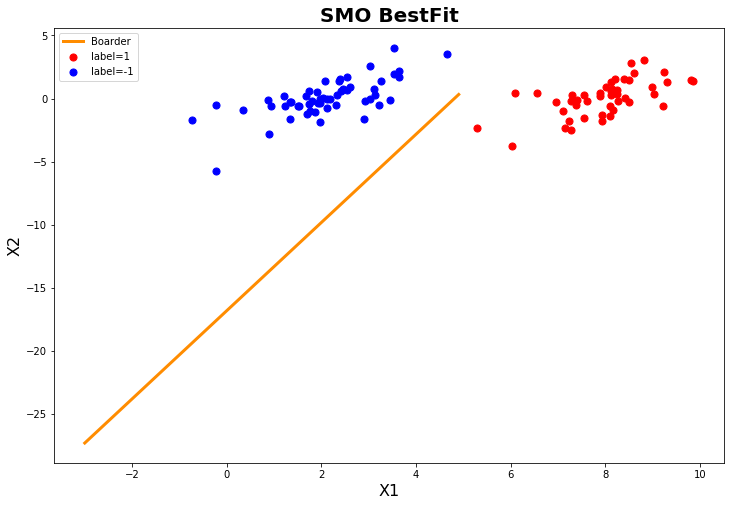

In [6]:
dataMat1,labelMat1=loadDataSet("testSet.txt") #加载数据集
start=time.time()
b1,alphas1=SMOsimple(dataMat1,labelMat1,0.6,0.001,100)
print ("\n","time used:.{0}s".format(time.time()-start))
w1=weight(dataMat1,labelMat1,alphas1)
plotBestFit(w1,b1,"testSet.txt")